In [1]:
import pandas as pd
import cvxpy as cp
import numpy as np
import docplex.mp.model as md
from docplex.mp.conflict_refiner import ConflictRefiner 
import scipy.stats as stats
import seaborn as sns
import matplotlib.patches as pch
import matplotlib.pyplot as plt


# 加载数据


In [2]:
phase = np.loadtxt("phase")
cir=phase[0].sum()
phase=phase/cir
vol = np.loadtxt("volume")
qv = np.loadtxt("path_vol")
phase_get = np.load("phase_get.npy")
d = np.loadtxt("distance")
# dr = np.loadtxt("dr")
# dr=dr/cir
straight_get = np.load("straight_get.npy")

srl_get=np.load("srl_get.npy")
ison = np.array([0, 0, 0, 1, 1, 1])
px = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
pxb = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
qb=[120,120]


In [3]:
def get_rf(d,p):
    tmp=[]
    for i,a in enumerate(p):
        idx=np.where(a!=0)[0]
        a=a&0
        if len(idx)>0:
            a[:idx[0]]=1
        tmp.append((d[i]*a).sum())
    return tmp

## 速度数据


In [4]:
lower, upper = 8, 12
linspace = np.arange(lower, upper, 1)
lin_num = len(linspace)

# 南北直行方向绿灯时间
sg=np.array([(straight_get[i]*phase).sum(axis=1) for i in range(len(straight_get))])
srf=np.array([get_rf(phase,straight_get[i]) for i in range(len(srl_get))])

## 长干道数据


In [5]:
rho = vol[0] / vol[1]
num = len(vol[0])
numr = len(qv)
nump = len(phase_get)
M = 1e6
nx = 0.00000001
be = 8
speedScope = np.array([lower, upper])
speedVar = np.array([-2, 2])

g=np.array([(phase_get[i]*phase).sum(axis=1) for i in range(numr) ])
r=1-g
rf=np.array([get_rf(phase,phase_get[i]) for i in range(numr)])

ex=[0,1,1,0,1,0,1,1,0,1,1,0,1,1]
dwt=15

# 定义变量


### 通用变量

In [6]:
model = md.Model("prosmodel")
Z_list = [(i) for i in range(num)]
z = model.continuous_var_dict(Z_list, lb=1 / 180, ub=1 / 80, name="z")

o_list = [(i) for i in range(num)]
o = model.continuous_var_dict(o_list, lb=0, ub=1, name="o")

t_list = [(i, k) for i in range(2) for k in range(num-1)]
t = model.continuous_var_dict(t_list, lb=0, name="t")


### 长干道变量

In [7]:
p_list = [(i) for i in range(num)]
p = model.binary_var_dict(p_list, name="p")

w_list = [(i, k) for i in range(numr) for k in range(num)]
w = model.continuous_var_dict(w_list, lb=0, ub=1, name="w")

b_list = [(i, k) for i in range(numr) for k in range(num)]
b = model.continuous_var_dict(b_list, lb=0, ub=1, name="b")

n_list = [(i, k) for i in range(numr) for k in range(num)]
n = model.integer_var_dict(n_list, lb=0, ub=10, name="n")

u_list = [(i, k) for i in range(numr) for k in range(num)]
u = model.continuous_var_dict(u_list, lb=0, ub=1, name="u")

y_list = [(i, k) for i in range(numr) for k in range(num)]
y = model.binary_var_dict(y_list, name="y")


# 长干道模型

## 长干道约束

保障路径$i$的绿波带宽出现出现在交叉口$k$内：
$$
\begin{cases}
b_{i,k}/2+\Delta_k\leq w_{i,k}\leq 1-r_{i,k}-b_{i,k}/2\\
\bar{b}_{i,k}/2+\bar{\Delta}_k\leq \bar{w}_{i,k} \leq 1-r_{i,k}-\bar{b}_{i,k}/2
\end{cases}
$$


In [8]:
for k in range(num):
    for i in range(numr):
        model.add_constraint(b[i, k] / 2<= w[i, k]-px[ison[i],k])
        model.add_constraint(w[i, k] <= g[i][k] - b[i, k] / 2)


路径$i$的绿波带宽出现再交叉口$k+1$绿灯时间内
$$
\begin{cases}
b_{i,k}/2 -M*p_{k+1}\leq w_{i,k+1}\leq 1-r_{i,k+1}-b_{i,k}/2 +M*p_{k+1}\\
\bar{b}_{i,k+1}/2 -M*p_k\leq \bar{w}_{i,k} \leq 1-r_{i,k}-\bar{b}_{i,k+1}/2+M*p_k
\end{cases}
$$

In [9]:
# for k in range(num-1):
#     for i in range(numr):
#         if ison[i]==0:
#             model.add_constraints([b[i,k]/2-M*p[k+1]<=w[i,k+1],w[i,k+1]<=g[i,k+1]-b[i,k]/2+M*p[k+1]])
#         else:
#             model.add_constraints([b[i,k+1]/2-M*p[k]<=w[i,k],w[i,k]<=g[i,k]-b[i,k+1]/2+M*p[k]])

速度变化区间为：
$$
\begin{cases}
\frac{d_k}{f_k}z\leq t_k \leq \frac{d_k}{e_k}z\\
\frac{\bar{d}_k}{\bar{f}_k}z \leq \bar{t}_k \leq \frac{\bar{d}_k}{\bar{e}_k}z\\
\frac{d_k}{h_k}z\leq \frac{d_k}{d_{k+1}}t_{k+1}-t_k \leq \frac{d_k}{g_k}z\\
\frac{\bar{d}_k}{\bar{h}_k}z \leq \frac{\bar{d}_k}{\bar{d}_{k+1}}\bar{t}_{k+1}-\bar{t}_k\leq \frac{\bar{d}_k}{\bar{g_k}}z
\end{cases}
$$

In [10]:
for k in range(num-1):
    model.add_constraint(d[k] / speedScope[1] * z[k] <= t[0, k])
    model.add_constraint(t[0, k] <= d[k] / speedScope[0] * z[k])

    model.add_constraint(d[k] / speedScope[1] * z[k] <= t[1, k])
    model.add_constraint(t[1, k] <= d[k] / speedScope[0] * z[k])

for k in range(num-2):
    model.add_constraint(d[k] / speedVar[0] * z[k] <= d[k] / d[k+1] * t[0, k + 1] - t[0, k])
    model.add_constraint(d[k]/d[k+1] * t[0, k + 1] - t[0, k] <= d[k] / speedVar[1] * z[k])

    model.add_constraint(d[k] / speedVar[0] * z[k] <= d[k]/d[k+1] * t[1, k + 1] - t[1, k])
    model.add_constraint(d[k]/d[k+1] * t[1, k + 1] - t[1, k] <= d[k] / speedVar[1] * z[k])

确保每个子区至少包含两个交叉口：
$$p_k+p_{k+1}<=1$$

In [11]:
for k in range(num-1):
    model.add_constraint(p[k] + p[k + 1] <= 1)

交叉口偏移量$\mu_{i,k}$，表示当交叉口$k$为干道分割点时，路径$i$在交叉口的偏移量，即当$p_k=1$时，$\tau_{i,k}>0$,否则，$\mu_{i,k}=0$,约束表达为：
$$
\epsilon p_k\leq \mu_{i,k}\leq p_k
$$

In [12]:
for k in range(num):
    for i in range(numr):
        model.add_constraints([nx * p[k] <= u[i, k], u[i, k] <= p[k]])

当路径$i$在交叉口$k$取得非零带宽，则应满足如下约束:
$$\begin{cases}
beZ_k-M (1-y_{i,k})\leq b_{i,k}\leq y_{i,k} \\
beZ_k-M (1-\bar{y}_{i,k})\leq \bar{b}_{i,k}\leq \bar{y}_{i,k}
\end{cases}
$$

In [13]:
for k in range(num):
    for i in range(numr):
        model.add_constraint(be * z[k] - M * (1 - y[i, k]) <= b[i, k])
        model.add_constraint(b[i, k] <= y[i, k])


相同分段子区内部的交叉口绿波带宽相同，约束表达为：
$$\begin{cases}
-M p_{k+1}\leq b_{i,k}-b_{i,k+1}\leq M p_{k+1}\\
-M p_{k}\leq \bar{b}_{i,k}-\bar{b}_{i,k+1}\leq M p_{k}
\end{cases}
$$

为避免路径产生无效带宽，引入二进制变量$y_{i,k}$,其定义如下：
$$
y_{i,k}=\begin{cases}
1,&\text{如果路径$i$在交叉口$k$能够获得有效非零带宽}\\
0,& \text{其他}
\end{cases}
$$

路径$i$在相同分组内取得相等带宽，进而约束相同分组内交叉口同时取得非零带宽，在不同分组可能无法取得带宽，其约束表达如下：

$$\begin{cases}
-M p_{k+1}\leq y_{i,k}-y_{i,k+1}\leq M p_{k+1}\\
-M p_{k}\leq \bar{y}_{i,k}-\bar{y}_{i,k+1}\leq M p_{k}
\end{cases}
$$

其含义为，当路径$i$在交叉口$k$能够取得非零带宽,则其带宽应大于基础带宽$be$

因引入$y_{i,k}$，当路径$i$在交叉口$k$无法取得有效带宽时，其循环整形约束应不再起作用，循环整形约束可修改为:

$$
\begin{cases}
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\geq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}-M(1-y_{i,k})\\
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\leq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}+M(1-y_{i,k})\\ 
\end{cases}
$$

$$
\begin{cases}
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\geq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}-M(1-y_{i,k})\\
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\leq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}+M(1-y_{i,k})
\end{cases}
$$

In [14]:
def add_split_on_cons(i):
    for k in range(num-1):
        model.add_constraint(o[k] + rf[i, k] + w[i, k] + t[0, k] + u[i, k+1] >=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + n[i, k + 1] - M * (1 - y[i, k+1]))
        model.add_constraint(o[k] + rf[i, k] + w[i, k] + t[0, k] + u[i, k+1] <=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + n[i, k + 1] + M * (1 - y[i, k+1]))

        # model.add_constraint(-M * p[k+1] <= b[i, k] - b[i, k + 1])
        # model.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k+1])

        model.add_constraint(-M * p[k+1] <= y[i, k + 1] - y[i, k])
        model.add_constraint(y[i, k + 1] - y[i, k] <= M * p[k+1])

        model.add_constraints([b[i,k]/2-M*p[k+1]<=w[i,k+1],w[i,k+1]<=g[i,k+1]-b[i,k]/2+M*p[k+1]])

def add_split_in_cons(i):
    for k in range(num-1):
        model.add_constraint(o[k] + rf[i, k] + w[i, k] + n[i, k] >=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + t[1, k] + u[i, k] - M * (1 - y[i, k+1]))
        model.add_constraint(o[k] + rf[i, k] + w[i, k] + n[i, k] <=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + t[1, k] + u[i, k] + M * (1 - y[i, k+1]))

        # model.add_constraint(-M * p[k+1] <= b[i, k] - b[i, k + 1])
        # model.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k+1])

        model.add_constraint(-M * p[k+1] <= y[i, k + 1] - y[i, k])
        model.add_constraint(y[i, k + 1] - y[i, k] <= M * p[k+1])
        
        model.add_constraints([b[i,k+1]/2-M*p[k+1]<=w[i,k],w[i,k]<=g[i,k]-b[i,k+1]/2+M*p[k+1]])


In [15]:
model.add_constraint(o[0]==0)
for i in range(numr):
    if ison[i]==0:
        add_split_on_cons(i)
    elif ison[i]==1:
        add_split_in_cons(i)

注意到某些情况下，模型可能更偏好某一方向带宽，从而将其他方向的带宽设置为0，为避免这种情况的发生，同时体现模型对上行（下行）方向的偏好，定义约束：

$$
(1-\rho_{k})\sum_i b_{i,k}\geq (1-\rho_{k})\rho_{k} \sum_i \bar{b}_{i,k}
$$

In [16]:
for k in range(num):
    model.add_constraint((1 - rho[k]) * model.sum([b[i, k]*(1-ison[i]) for i in range(numr)])>=\
         (1 - rho[k])* rho[k]* model.sum([b[i, k]*ison[i] for i in range(numr)]))

因干道分割可对长干道进行分组，组内实现干道协调，不同组之间互不影响，因此不同分组可采用不同的信号协调周期，其约束表达如下：

$$
\begin{cases}
Z_{min}\leq Z_k\leq Z_{max}\\
-Mp_{k+1}\leq Z_{k+1}-Z_{k}\leq MP_{k+1}
\end{cases}
$$

In [17]:
for k in range(num-1):
    model.add_constraint(-M * p[k + 1] <= z[k + 1] - z[k])
    model.add_constraint(z[k + 1] - z[k] <= M * p[k + 1])

通过该约束，可实现在不同分段子区之间，可采用不同的信号周期，避免过长的干道采用相同信号周期造成部分交叉口车辆延误过大

## 公交约束

### 变量定义

In [18]:
wb_list = [(i, k) for i in range(2) for k in range(num)]
wb = model.continuous_var_dict(wb_list, lb=0, ub=1, name="wb")

bb_list = [(i, k) for i in range(2) for k in range(num)]
bb = model.continuous_var_dict(bb_list, lb=0, ub=1, name="bb")

nb_list = [(i, k) for i in range(2) for k in range(num)]
nb = model.integer_var_dict(nb_list, lb=0, ub=10, name="nb")

dw_list=[(i, k) for i in range(2) for k in range(num-1)]
dw=model.continuous_var_dict(dw_list,lb=0,ub=1,name="dw")

tb_list=[(i, k) for i in range(2) for k in range(num-1)]
tb=model.continuous_var_dict(tb_list,lb=0,ub=1,name="tb")


### 添加约束

In [19]:
for k in range(num-1):
    model.add_constraint(d[k] / speedScope[1] * z[k] <= tb[0, k]-ex[k]*dwt*z[k]-dw[0,k])
    model.add_constraint(tb[0, k]-ex[k]*dwt*z[k]-dw[0,k] <= d[k] / speedScope[0] * z[k])

    model.add_constraint(d[k] / speedScope[1] * z[k] <= tb[1, k]-ex[k]*dwt*z[k]-dw[1,k])
    model.add_constraint(tb[1, k]-ex[k]*dwt*z[k]-dw[1,k] <= d[k] / speedScope[0] * z[k])

for k in range(num-2):
    model.add_constraint(d[k] / speedVar[0] * z[k] <= 
    d[k]/d[k+1]*(tb[0, k + 1]-ex[k+1]*dwt*z[k]-dw[0,k+1])- (tb[0, k]-ex[k]*dwt*z[k]-dw[0,k]))
    model.add_constraint(d[k]/d[k+1]*(tb[0, k + 1]-ex[k+1]*dwt*z[k]-dw[0,k+1])- (tb[0, k]-ex[k]*dwt*z[k]-dw[0,k]) <=
     d[k] / speedVar[1] * z[k])

    model.add_constraint(d[k] / speedVar[0] * z[k] <=
    d[k]/d[k+1]*(tb[1, k + 1]-ex[k+1]*dwt*z[k]-dw[1,k+1])- (tb[1, k]-ex[k]*dwt*z[k]-dw[1,k]))
    model.add_constraint(d[k]/d[k+1]*(tb[1, k + 1]-ex[k+1]*dwt*z[k]-dw[1,k+1])-(tb[1, k]-ex[k]*dwt*z[k]-dw[1,k])<=
     d[k] / speedVar[1] * z[k])

In [20]:
for k in range(num):
    for i in range(2):
        model.add_constraint(bb[i,k]/2<=wb[i,k]-pxb[i,k]) 
        model.add_constraint(wb[i,k]<=sg[i,k]-bb[i,k]/2)      

# for  k in range(num-1):
#     model.add_constraint(bb[0,k]/2+M*p[k]<=wb[0,k+1])
#     model.add_constraint(wb[0,k+1]<=sg[0,k+1]-bb[0,k]/2)

#     model.add_constraints([bb[1,k+1]/2<=wb[1,k],wb[1,k]<=sg[1,k]-bb[1,k+1]/2])

for i in range(2):
    model.add_constraints([bb[i,k]>=be*z[k] for k in range(num)])

for k in range(num-1):
    for i in range(2):
        model.add_constraints([dw[i,k]<=ex[k]*15*z[k]])

因引入$y_{i,k}$，当路径$i$在交叉口$k$无法取得有效带宽时，其循环整形约束应不再起作用，循环整形约束可修改为:

$$
\begin{cases}
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\geq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}-M(1-y_{i,k})\\
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\leq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}+M(1-y_{i,k})\\ 
\end{cases}
$$

$$
\begin{cases}
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\geq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}-M(1-y_{i,k})\\
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\leq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}+M(1-y_{i,k})
\end{cases}
$$

In [21]:

for k in range(num-1):
    model.add_constraint(o[k] + srf[0, k] + wb[0, k] + tb[0, k] <=
                            o[k + 1] + srf[0, k+1] + wb[0, k + 1] + nb[0, k + 1]+M*p[k+1])
    model.add_constraint(o[k] + srf[0, k] + wb[0, k] + tb[0, k]  >=
                            o[k + 1] + srf[0, k+1] + wb[0, k + 1] + nb[0, k + 1] - M*p[k+1])

    model.add_constraints([bb[0,k]/2-M*p[k+1]<=wb[0,k+1],wb[0,k+1]<=sg[0,k+1]-bb[0,k]/2+M*p[k+1]])

    model.add_constraint(o[k] + srf[1, k] + wb[1, k] + nb[1, k] >=
                            o[k + 1] + srf[1, k+1] + wb[1, k + 1] + tb[1, k] - M * p[k+1] )
    model.add_constraint(o[k] + srf[1, k] + wb[1, k] + nb[1, k] <=
                            o[k + 1] + srf[1, k+1] + wb[1, k + 1] + tb[1, k] + M * p[k+1])
        
    model.add_constraints([bb[1,k+1]/2-M*p[k+1]<=wb[1,k],wb[1,k]<=sg[1,k]-bb[1,k+1]/2+M*p[k+1]])


## 长干道目标构建

目标函数包括三部分：
- 最大化每条路径各交叉口的的绿波带宽。
- 最小化分割点停车等待时间。
- 最小化分割次数，并限制分割点流量。
$$
MAX:\sum_{i=1}^{I}\left(\omega_1\sum_{k=1}^{\Omega_i}\left(q_{i}b_{i,k}+\bar{q}_{i}\bar{b}_{i,k} \right)-\omega_2
\sum_{k=1}^{\Omega_i}\left(q_{i}\mu_{i,k}+\bar{q}_{i}\bar{\mu}_{i,k}\right)\right)-\omega_3\sum_{k=1}^{\Omega_i}\left(p_k\left(Q_k+\bar{Q}_k\right)\right)
$$

In [22]:
sum_b = model.sum([qv[i] * b[i, k] for i in range(numr) for k in range(num)])
sum_u = model.sum([qv[i] * u[i, k] for i in range(numr) for k in range(num)])
sum_p = model.sum([p[k] * (vol[0, k] + vol[1, k]) for k in range(num)])
sum_bb=model.sum_vars(bb)*qb[0]

In [23]:
# model.maximize(sum_var)
model.set_multi_objective("max",[sum_b+sum_bb,sum_u,sum_p],weights=[5,-4,-2])
sol = model.solve(log_output=True)
print(sol.solve_details)
sol.objective_value

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125

Multi-objective solve log . . .

Index  Priority  Blend          Objective      Nodes  Time (sec.)  DetTime (ticks)

Performing restart 1
    1         0      3   1.9707224364e+04     382719        28.97         17214.99
status  = multi-objective optimal
time    = 28.984 s.
problem = MILP
gap     = 1.77735e+73%



5626

In [24]:
z = sol.get_value_dict(z)
t = sol.get_value_dict(t)
p = sol.get_value_dict(p)
y = sol.get_value_dict(y)
dw=sol.get_value_dict(dw)
tb=sol.get_value_dict(tb)

# 速度波动

## 定义变量

In [25]:
mdl=md.Model("variable_speed")

o_list = [(i) for i in range(num)]
o = mdl.continuous_var_dict(o_list, lb=0, ub=1, name="o")
### 速度波动变量
yp_list=[(i,j,k) for i in range(2) for j in range(num) for k in range(lin_num)]
yp=mdl.binary_var_dict(yp_list,name="yp")

nt_list = [(i, j, k) for i in range(2) for j in range(num) for k in range(lin_num)]
nt = mdl.integer_var_dict(nt_list, lb=0, ub=10, name="nt")

C_list=[(i,j,k) for i in range(2) for j in range(num) for k in range(lin_num)]
C=mdl.continuous_var_dict(C_list,lb=0,ub=1,name="C")

pc_list=[(i,j,k) for i in range(2) for j in range(num) for k in range(lin_num)]
pc=mdl.binary_var_dict(pc_list,name="pc")

w_list = [(i, k) for i in range(numr) for k in range(num)]
w = mdl.continuous_var_dict(w_list, lb=0, ub=1, name="w")

b_list = [(i, k) for i in range(numr) for k in range(num)]
b = mdl.continuous_var_dict(b_list, lb=0, ub=1, name="b")

n_list = [(i, k) for i in range(numr) for k in range(num)]
n = mdl.integer_var_dict(n_list, lb=0, ub=10, name="n")

u_list = [(i, k) for i in range(numr) for k in range(num)]
u = mdl.continuous_var_dict(u_list, lb=0, ub=1, name="u")

M=1e6

## 构建约束

### 长干道约束

保障路径$i$的绿波带宽出现出现在交叉口$k$内：
$$
\begin{cases}
b_{i,k}/2+\Delta_k\leq w_{i,k}\leq 1-r_{i,k}-b_{i,k}/2\\
\bar{b}_{i,k}/2+\bar{\Delta}_k\leq \bar{w}_{i,k} \leq 1-r_{i,k}-\bar{b}_{i,k}/2
\end{cases}
$$


In [26]:
for k in range(num):
    for i in range(numr):
        mdl.add_constraint(b[i, k] / 2<= w[i, k]-px[ison[i],k])
        mdl.add_constraint(w[i, k] <= g[i][k] - b[i, k] / 2)


路径$i$的绿波带宽出现再交叉口$k+1$绿灯时间内
$$
\begin{cases}
b_{i,k}/2 -M*p_{k+1}\leq w_{i,k+1}\leq 1-r_{i,k+1}-b_{i,k}/2 +M*p_{k+1}\\
\bar{b}_{i,k+1}/2 -M*p_k\leq \bar{w}_{i,k} \leq 1-r_{i,k}-\bar{b}_{i,k+1}/2+M*p_k
\end{cases}
$$

In [27]:
# for k in range(num-1):
#     for i in range(numr):
#         if ison[i]==0:
#             mdl.add_constraints([b[i,k]/2-M*p[k+1]<=w[i,k+1],w[i,k+1]<=g[i,k+1]-b[i,k]/2+M*p[k+1]])
#         else:
#             mdl.add_constraints([b[i,k+1]/2-M*p[k]<=w[i,k],w[i,k]<=g[i,k]-b[i,k+1]/2+M*p[k]])

交叉口偏移量$\mu_{i,k}$，表示当交叉口$k$为干道分割点时，路径$i$在交叉口的偏移量，即当$p_k=1$时，$\tau_{i,k}>0$,否则，$\mu_{i,k}=0$,约束表达为：
$$
\epsilon p_k\leq \mu_{i,k}\leq p_k
$$

In [28]:
for k in range(num):
    for i in range(numr):
        mdl.add_constraints([nx * p[k] <= u[i, k], u[i, k] <= p[k]])

当路径$i$在交叉口$k$取得非零带宽，则应满足如下约束:
$$\begin{cases}
beZ_k-M (1-y_{i,k})\leq b_{i,k}\leq y_{i,k} \\
beZ_k-M (1-\bar{y}_{i,k})\leq \bar{b}_{i,k}\leq \bar{y}_{i,k}
\end{cases}
$$

In [29]:
for k in range(num):
    for i in range(numr):
        mdl.add_constraint(be * z[k] - M * (1 - y[i, k]) <= b[i, k])
        mdl.add_constraint(b[i, k] <= y[i, k])

相同分段子区内部的交叉口绿波带宽相同，约束表达为：
$$\begin{cases}
-M p_{k+1}\leq b_{i,k}-b_{i,k+1}\leq M p_{k+1}\\
-M p_{k}\leq \bar{b}_{i,k}-\bar{b}_{i,k+1}\leq M p_{k}
\end{cases}
$$

为避免路径产生无效带宽，引入二进制变量$y_{i,k}$,其定义如下：
$$
y_{i,k}=\begin{cases}
1,&\text{如果路径$i$在交叉口$k$能够获得有效非零带宽}\\
0,& \text{其他}
\end{cases}
$$

路径$i$在相同分组内取得相等带宽，进而约束相同分组内交叉口同时取得非零带宽，在不同分组可能无法取得带宽，其约束表达如下：

$$\begin{cases}
-M p_{k+1}\leq y_{i,k}-y_{i,k+1}\leq M p_{k+1}\\
-M p_{k}\leq \bar{y}_{i,k}-\bar{y}_{i,k+1}\leq M p_{k}
\end{cases}
$$

其含义为，当路径$i$在交叉口$k$能够取得非零带宽,则其带宽应大于基础带宽$be$

因引入$y_{i,k}$，当路径$i$在交叉口$k$无法取得有效带宽时，其循环整形约束应不再起作用，循环整形约束可修改为:

$$
\begin{cases}
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\geq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}-M(1-y_{i,k})\\
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\leq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}+M(1-y_{i,k})\\ 
\end{cases}
$$

$$
\begin{cases}
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\geq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}-M(1-y_{i,k})\\
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\leq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}+M(1-y_{i,k})
\end{cases}
$$

In [30]:
def add_split_on_cons(i):
    for k in range(num-1):
        mdl.add_constraint(o[k] + rf[i, k] + w[i, k] + t[0, k] + u[i, k+1] >=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + n[i, k + 1] - M * (1 - y[i, k+1]))
        mdl.add_constraint(o[k] + rf[i, k] + w[i, k] + t[0, k] + u[i, k+1] <=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + n[i, k + 1] + M * (1 - y[i, k+1]))

        # mdl.add_constraint(-M * p[k+1] <= b[i, k] - b[i, k + 1])
        # mdl.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k+1])

        mdl.add_constraints([b[i,k]/2-M*p[k+1]<=w[i,k+1],w[i,k+1]<=g[i,k+1]-b[i,k]/2+M*p[k+1]])

def add_split_in_cons(i):
    for k in range(num-1):
        mdl.add_constraint(o[k] + rf[i, k] + w[i, k] + n[i, k] >=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + t[1, k] + u[i, k] - M * (1 - y[i, k+1]))
        mdl.add_constraint(o[k] + rf[i, k] + w[i, k] + n[i, k] <=
                             o[k + 1] + rf[i, k+1] + w[i, k + 1] + t[1, k] + u[i, k] + M * (1 - y[i, k+1]))

        # mdl.add_constraint(-M * p[k+1] <= b[i, k] - b[i, k + 1])
        # mdl.add_constraint(b[i, k] - b[i, k + 1] <= M * p[k+1])
        
        mdl.add_constraints([b[i,k+1]/2-M*p[k+1]<=w[i,k],w[i,k]<=g[i,k]-b[i,k+1]/2+M*p[k+1]])


In [31]:
mdl.add_constraint(o[0]==0)
for i in range(numr):
    if ison[i]==0:
        add_split_on_cons(i)
    elif ison[i]==1:
        add_split_in_cons(i)

注意到某些情况下，模型可能更偏好某一方向带宽，从而将其他方向的带宽设置为0，为避免这种情况的发生，同时体现模型对上行（下行）方向的偏好，定义约束：

$$
(1-\rho_{k})\sum_i b_{i,k}\geq (1-\rho_{k})\rho_{k} \sum_i \bar{b}_{i,k}
$$

In [32]:
for k in range(num):
    mdl.add_constraint((1 - rho[k]) * mdl.sum([b[i, k]*(1-ison[i]) for i in range(numr)])>=\
         (1 - rho[k])* rho[k]* mdl.sum([b[i, k]*ison[i] for i in range(numr)]))

### 公交约束

#### 变量定义

In [33]:
wb_list = [(i, k) for i in range(2) for k in range(num)]
wb = mdl.continuous_var_dict(wb_list, lb=0, ub=1, name="wb")

bb_list = [(i, k) for i in range(2) for k in range(num)]
bb = mdl.continuous_var_dict(bb_list, lb=0, ub=1, name="bb")

nb_list = [(i, k) for i in range(2) for k in range(num)]
nb = mdl.integer_var_dict(nb_list, lb=0, ub=10, name="nb")


#### 添加约束

In [34]:
for k in range(num):
    for i in range(2):
        mdl.add_constraint(bb[i,k]/2<=wb[i,k]-pxb[i,k]) 
        mdl.add_constraint(wb[i,k]<=sg[i,k]-bb[i,k]/2)      

for i in range(2):
    mdl.add_constraints([bb[i,k]>=be*z[k] for k in range(num)])

因引入$y_{i,k}$，当路径$i$在交叉口$k$无法取得有效带宽时，其循环整形约束应不再起作用，循环整形约束可修改为:

$$
\begin{cases}
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\geq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}-M(1-y_{i,k})\\
\theta_k+r_{i,k}+\varphi_{i,k}+w_{i,k}+t_{k}+\mu_{k+1}\leq \theta_{k+1}+r_{i,k+1}+\varphi_{i,k+1}+w_{i,k+1}+n_{i,k+1}+M(1-y_{i,k})\\ 
\end{cases}
$$

$$
\begin{cases}
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\geq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}-M(1-y_{i,k})\\
\theta_k+\bar{r}_{i,k}+\bar{\varphi}_{i,k}+\bar{w}_{i,k}+\bar{n}_{i,k}\leq\theta_{k+1}+\bar{r}_{i,k+1}+\bar{\varphi}_{i,k+1}+\bar{w}_{i,k+1}+\bar{t}_{k}+\bar{\mu}_{k}+M(1-y_{i,k})
\end{cases}
$$

In [35]:

for k in range(num-1):
    mdl.add_constraint(o[k] + srf[0, k] + wb[0, k] + tb[0, k] <=
                            o[k + 1] + srf[0, k+1] + wb[0, k + 1] + nb[0, k + 1]+M*p[k+1])
    mdl.add_constraint(o[k] + srf[0, k] + wb[0, k] + tb[0, k]  >=
                            o[k + 1] + srf[0, k+1] + wb[0, k + 1] + nb[0, k + 1] - M*p[k+1])

    mdl.add_constraints([bb[0,k]/2-M*p[k+1]<=wb[0,k+1],wb[0,k+1]<=sg[0,k+1]-bb[0,k]/2+M*p[k+1]])

    mdl.add_constraint(o[k] + srf[1, k] + wb[1, k] + nb[1, k] >=
                            o[k + 1] + srf[1, k+1] + wb[1, k + 1] + tb[1, k] - M * p[k+1] )
    mdl.add_constraint(o[k] + srf[1, k] + wb[1, k] + nb[1, k] <=
                            o[k + 1] + srf[1, k+1] + wb[1, k + 1] + tb[1, k] + M * p[k+1])
        
    mdl.add_constraints([bb[1,k+1]/2-M*p[k+1]<=wb[1,k],wb[1,k]<=sg[1,k]-bb[1,k+1]/2+M*p[k+1]])


### 速度波动约束

插入图片

车辆速度在速度区间$[7.3,14.2]$内呈$X~N(9,1)$的正态分布，分布表示如下：
$$
f(x)=\frac{1}{\sqrt{2\pi}}e^{-\frac{(x-9)^2}{2}}
$$
$$
f(x)=\frac{1}{\sigma\sqrt{2*\pi}}e^{-\frac{x-\mu}{2\sigma^2}}
$$

In [36]:
def getprop(linspace1,linspace2,mu,sigma):
    t1=stats.norm(mu,sigma).cdf(linspace1)
    t2=stats.norm(mu,sigma).cdf(linspace2)
    return t2-t1

In [37]:
mu=9
sigma=np.sqrt(2)
print(linspace)
ProDistribution=getprop(linspace-0.25,linspace+0.25,mu,sigma)
np.around(ProDistribution,2)

[ 8  9 10 11]


array([0.11, 0.14, 0.11, 0.05])

$i$表示路径，$j$表示相位，$k$表示交叉口
- $A_k$ ：表示上行带宽所处红灯结束（绿灯开始时间）点位

- $B_k$: 表示上行带宽所处绿灯结束（红灯开始时间）点位

- $A_{k}^{\prime}$:上行带宽与交叉口相位的左侧交点

- $B_{k}^{\prime}$:上行带宽与交叉口相位的右侧交点

- $\bar{A}_{k}$：表示下行带宽所处红灯结束（绿灯开始时间）点位

-  $\bar{B}_{k}$: 表示下行带宽所处绿灯结束（红灯开始时间）点位

- $\bar{A}_{k}^{\prime}$:下行带宽与交叉口相位的左侧交点

- $\bar{B}_{k}^{\prime}$:下行带宽与交叉口相位的右侧交点
$$\begin{cases}
A_{k,v}=\theta_k+rs_k\\
B_{k,v}=\theta_k+r_k+gs_k\\
A_{k,v}^{\prime}=max\{A_{k-1,v}^{\prime}+d_{k-1}/v*z_k-M*(1-p_k),A_{k,v}+\tau_k+n_{k,v}\}\\
B_{k,v}^{\prime}=min\{B_{k-1,v}^{\prime}+d_{k-1}/v*z_k+M*(1-p_k),B_{k,v}+n_{k,v}\}\\
\bar{A}_{k}=\theta_k+\bar{rs}_k+\Delta_k\\
\bar{B}_{k}=\theta_k+\bar{rs}_k+\bar{gs}_k+\Delta_k\\
\bar{A}_{k,v}^{\prime}=max\{\bar{A}_{k+1,v}^{\prime}+d_{k}/v*z_k-M*(1-p_k),\bar{A}_{k,v}+\bar{\tau}_k+\bar{n}_{k,v}\}\\
\bar{B}_{k,v}^{\prime}=min\{\bar{B}_{k+1,v}^{\prime}+d_{k}/v*z_k+M*(1-p_k),\bar{B}_{k,v}+\bar{n}_{k,v}\}
\end{cases}
$$


In [38]:
def add_var_on_cons(A, B, o, r, g, t, n, k, end, yp, px, p,pc,C,onbound):
    if k>=end:
        mdl.add_constraint(pc[k-1]==yp[k-1])
        return onbound
    else:
        if p[k]==1:
            A1=o[k]+r[k]+n[k]+px[k]
            B1=o[k]+r[k]+n[k]+g[k]
        else:
            A1=mdl.max(A+t[k-1],o[k]+r[k]+n[k]+px[k])
            B1=mdl.min(B+t[k-1], o[k]+r[k]+n[k]+g[k])
        # A1=model.max(A+t[k-1]-M*p[k],o[k]+r[k]+n[k]+px[k])
        # B1=model.min(B+t[k-1]+M*p[k], o[k]+r[k]+n[k]+g[k])

        mdl.add_if_then(pc[k]==1,C[k]==B1-A1)
        mdl.add_if_then(pc[k]==0,C[k]==0)
        # mdl.add_constraints([C[k]<=(B1-A1)+(1-pc[k]),C[k]>=(B1-A1)-M*(1-pc[k]),C[k]>=-M*pc[k],C[k]<=M*pc[k]])

        mdl.add_constraints([be*z[k]-M*(1-yp[k]) <= B1-A1, B1-A1 <= g[k]+M*(1-yp[k])])
        mdl.add_constraints([p[k]>=pc[k-1],yp[k-1]>=pc[k-1],pc[k-1]>=p[k]+yp[k-1]-1])
        onbound.append([A1,B1,B1-A1])
        return add_var_on_cons(A1, B1, o, r, g, t, n, k+1, end, yp, px, p,pc,C,onbound)

def add_var_in_cons(A, B, o, r, g, t, n, k, end, yp, px, p,pc,C,inbound):
    if k<=end:
        mdl.add_constraints([p[k+1]>=pc[k+1],yp[k+1]>=pc[k+1],p[k+1]+yp[k+1]-1<=pc[k+1]])
        # mdl.add_constraint(pc[num-1]==yp[num-1])
        return inbound
    else:
        A1=mdl.max(A+t[k],o[k]+r[k]+n[k]+px[k])
        B1=mdl.min(B+t[k], o[k]+r[k]+n[k]+g[k])
        # A=mdl.max(A+t[k]-M*p[k], o[k]+r[k]+n[k]+px[k])
        # B=mdl.min(B+t[k]+M*p[k], o[k]+r[k]+g[k]+n[k])
        
        mdl.add_constraints([be*z[k]-M*(1-yp[k]) <= B1-A1, B1-A1 <= g[k]+M*(1-yp[k])])
        mdl.add_constraints([p[k+1]>=pc[k+1],yp[k+1]>=pc[k+1],p[k+1]+yp[k+1]-1<=pc[k+1]])
        # mdl.add_constraints([p[k+1]>=pc[k],yp[k]>=pc[k],pc[k]>=p[k+1]+yp[k]-1])

        mdl.add_if_then(pc[k]==1,C[k]==B1-A1)
        mdl.add_if_then(pc[k]==0,C[k]==0)
        inbound.append([A1,B1,B1-A1])
        if p[k]==1:
            A1=o[k]+r[k]+n[k]+px[k]
            B1=o[k]+r[k]+n[k]+g[k]
        # else:
        # mdl.add_constraints([C[k]<=(B1-A1)+(1-pc[k]),C[k]>=(B1-A1)-M*(1-pc[k]),C[k]>=-M*pc[k],C[k]<=M*pc[k]])
        return add_var_in_cons(A1, B1, o, r, g, t, n, k-1, end, yp, px, p,pc,C,inbound)

In [39]:
sum_on=0
sum_in=0
onbound_x=[]
inbound_x=[]
for i,v in enumerate(linspace):
    A_on_0=o[0]+srf[0,0]
    B_on_0=o[0]+srf[0,0]+sg[0,0]
    mdl.add_if_then(pc[0,0,i]==1,C[0,0,i]==B_on_0-A_on_0)
    mdl.add_if_then(pc[0,0,i]==0,C[0,0,i]==0)
    # mdl.add_constraints([C[0,0,i]<=(B_on_0-A_on_0)+M*(1-pc[0,0,i]),C[0,0,i]>=(B_on_0-A_on_0)-M*(1-pc[0,0,i]),
    # C[0,0,i]>=-M*pc[0,0,i],C[0,0,i]<=M*pc[0,0,i]])
    onb=add_var_on_cons(
        A=A_on_0,
        B=B_on_0,
        o=o,
        r=srf[0],
        g=sg[0],
        t=np.array([d[j]/v*z[j] for j in range(num-1)]),
        n=np.array([nt[0,j,i] for j in range(num)]),
        k=1,
        end=num,
        yp=np.array([yp[0,j,i] for j in range(num)]),
        px=px[0],
        p=np.array([p[k] for k in range(num)]),
        pc=np.array([pc[0,j,i] for j in range(num)]),
        C=[C[0,k,i] for k in range(num)],
        onbound=[[o[0]+srf[0,0],o[0]+srf[0,0]+sg[0,0],o[0]+sg[0,0]]]
    )
    sum_on+=mdl.sum([C[0,k,i]*vol[0,k] for k in range(num)])*ProDistribution[i]
    onbound_x.append(onb)
    
    A_in_0=o[num-1]+srf[1,num-1]
    B_in_0=o[num-1]+srf[1,num-1]+sg[1,num-1]
    mdl.add_if_then(pc[1,num-1,i]==1,C[1,num-1,i]==B_in_0-A_in_0)
    mdl.add_if_then(pc[1,num-1,i]==0,C[1,num-1,i]==0)
    mdl.add_constraints([C[1,num-1,i]<=(B_in_0-A_in_0)+M*(1-pc[1,num-1,i]),C[1,num-1,i]>=(B_in_0-A_in_0)-M*(1-pc[1,num-1,i]),
    C[1,num-1,i]>=-M*pc[1,num-1,i],C[1,num-1,i]<=M*pc[1,num-1,i]])
    inb=add_var_in_cons(
        A=A_in_0,
        B=B_in_0,
        o=o,
        r=srf[1],
        g=sg[1],
        t=np.array([d[j]/v*z[j] for j in range(num-1)]),
        n=np.array([nt[1,j,i] for j in range(num)]),
        k=num-2,
        end=-1,
        yp=np.array([yp[1,j,i] for j in range(num)]),
        px=px[1],
        p=p,
        pc=np.array([pc[1,j,i] for j in range(num)]),
        C=[C[1,k,i] for k in range(num)],
        inbound=[[A_in_0,B_in_0,o[0]+sg[1,num-1]]]       
    )
    sum_in+=mdl.sum([C[1,k,i]*vol[1,k] for k in range(num)])*ProDistribution[i]
    inbound_x.append(inb)

为避免某些速度下无法取得有效带宽，进而影响其他速度下的带宽，可尽量
$$
\eta_{k,v}=\begin{cases}
1,&\text{如果速度$v$在交叉口$k$下能够获得有效带宽}\\
0,& \text{其他}
\end{cases}
$$
$$
\begin{cases}
be*z_k-M(1-\eta_{k,v})\leq B^{\prime}_{k,v} -A ^{\prime}_{k,v} \leq \eta_{k,v}+M*(1-\eta_{k,v})\\
be*z_k-M(1-\bar{\eta}_{k,v})\leq B^{\prime}_{k,v} -A ^{\prime}_{k,v} \leq \bar{\eta}_{k,v}+M*(1-\bar{\eta}_{k,v})
\end{cases}
$$

为了保证带宽式中为正，应确保点$B^{\prime}_k(\bar{B}^{\prime}_k)$始终处于点$A^{\prime}_k(\bar{A}^{\prime}_k)$的右侧，约束表示为：
$$
\begin{cases}
-M*(1-\eta_{k,v})\leq B^{\prime}_{k,v}-A^{\prime}_{k,v}\leq g_{k}+M*(1-\eta_{k,v})\\
-M*(1-\bar{\eta}_{k,v} )\leq\bar{B}^{\prime}_{k,v}-\bar{A}^{\prime}_{k,v} \leq \bar{g}_k+M*(1-\bar{\eta}_{k,v})
\end{cases}
$$
$$
\begin{cases}
b_{k,v}=B_{k,v}^{\prime}-A_{k,v}^{\prime},& k=1,2,...,n,&v \in \Omega_v \\
\bar{b}_{k,v}=\bar{B}_{k,v}^{\prime}-\bar{A}_{k,v}^{\prime},& k=0,1,...,n-1,&v \in \Omega_v
\end{cases}
$$
$$
\begin{cases}
-Mp_{k+1}\leq\eta_{k,v}-\eta_{k+1,v}\leq Mp_{k+1}\\
-Mp_{k}\leq\bar{\eta}_{k,v}-\bar{\eta}_{k+1,v}\leq Mp_{k}
\end{cases}
$$

In [40]:
for k in range(num-1):
    for v in range(lin_num):
        mdl.add_constraints([-M*p[k+1] <= yp[0, k, v]-yp[0, k+1, v], yp[0, k, v]-yp[0, k+1, v] <= M*p[k+1]])
        mdl.add_constraints([-M*p[k+1] <= yp[1, k, v]-yp[1, k+1, v], yp[1, k, v]-yp[1, k+1, v] <= M*p[k+1]])


## 构建目标函数

速度波动目标函数为
$$
MAX: \sum_{v\in\Omega}\left(\omega_1\sum_{k=1}^{I}Q_kp_k\eta_{k,v}(B^{\prime}_{k,v}-A^{\prime}_{k,v})+\bar{Q}_kp_k\bar{\eta}_{k,v}(\bar{B}^{\prime}_{k,v}-\bar{A}^{\prime}_{k,v})\right)
$$

In [41]:
sum_b = mdl.sum([qv[i] * b[i, k] for i in range(numr) for k in range(num)])
sum_u = mdl.sum([qv[i] * u[i, k] for i in range(numr) for k in range(num)])
sum_bb=mdl.sum_vars(bb)*qb[0]
sum_v = sum_in+sum_on

In [42]:
refiner=ConflictRefiner()
res=refiner.refine_conflict(mdl)
res.display()

conflict(s): 0


In [43]:
mdl.set_multi_objective("max",[sum_b+sum_bb,sum_u,sum_v],priorities=[2,2,1],weights=[5,-4,1])
# mdl.set_multi_objective("max",[sum_b,sum_u],weights=[5,-4])
sol = mdl.solve(log_output=True)
print(sol.solve_details)
sol.objective_value

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125

Multi-objective solve log . . .

Index  Priority  Blend          Objective      Nodes  Time (sec.)  DetTime (ticks)

Performing restart 1
    1         2      2   2.6837224280e+04       5414         1.63           926.55

Performing restart 1

Performing restart 2
    2         1      1   4.2420337667e+02     228601        30.70         20205.32
status  = multi-objective optimal
time    = 32.359 s.
problem = MILP
gap     = 1.77735e+73%



5626

# 获取结果

In [44]:
o = sol.get_value_dict(o)
w = sol.get_value_dict(w)
n = sol.get_value_dict(n)
u = sol.get_value_dict(u)
b = sol.get_value_dict(b)
yp = sol.get_value_dict(yp)
pc=sol.get_value_dict(pc)
nt=sol.get_value_dict(nt)
C=sol.get_value_dict(C)
bb=sol.get_value_dict(bb)
wb=sol.get_value_dict(wb)
nb=sol.get_value_dict(nb)


In [45]:
Df=[[i for i in range(1,num+1)]]
Df+=[[d[i] for i in range(num-1)] + [np.nan]]
Df+=[[b[i,k] for k in range(num)] for i in range(numr)]
Df+=[[o[k] for k in range(num)]]
Df+=[[p[k] for k in range(num)]]
Df+=[[t[i,k] for k in range(num-1)]+[np.nan] for i in range(2)]
Df+=[[y[i,k] for k in range(num)] for i in range(numr)]
Df+=[[1/z[k] for k in range(num)]]
Df+=[[u[i,k] for k in range(num)] for i in range(numr)]
# Df+=[[yp[i,k,j] for k in range(num)] for j in range(lin_num) for i in range(2)]
Df+=[[bb[i,k] for k in range(num)] for i in range(2)]
Df+=[[(dw[i,k])/z[k]+dwt for k in range(num-1)]+[np.nan] for i in range(2)]
Df+=[[tb[i,k]/z[k] for k in range(num-1)]+[np.nan] for i in range(2)]
Df=np.array(Df)
Df=Df.T
Df=pd.DataFrame(Df)
cols=["cross_number"]
cols+=["distance"]
cols+=["b"+str(i) for i in range(1,numr+1)]
cols+=["offset","p"]
cols+=["t"+str(i) for i in range(1,3)]
cols+=["y"+str(i) for i in range(1,numr+1)]
cols+=["z"]
cols+=["u"+str(i) for i in range(1,numr+1)]
# cols+=["yp_on_"+str(i) for i in range(1,lin_num+1)]
# cols+=["yp_in_"+str(i) for i in range(1,lin_num+1)]

cols+=["bb"+str(i) for i in range(1,3)]
cols+=["dw"+str(i) for i in range(1,3)]
cols+=["tb"+str(i) for i in range(1,3)]

Df.columns=cols

Df["offset"] = Df.offset * Df.z
Df["t1"] = Df.t1 * Df.z
Df["t2"] = Df.t2 * Df.z
Df["b1"] = Df.b1 * Df.z
Df["b2"] = Df.b2 * Df.z
Df["b3"] = Df.b3 * Df.z
Df["b4"] = Df.b4 * Df.z
Df["b5"] = Df.b5 * Df.z
Df["b6"] = Df.b6 * Df.z
Df["bb1"]=Df.bb1*Df.z
Df["bb2"]=Df.bb2*Df.z
Df.round(2)

,cross_number,distance,b1,b2,b3,b4,b5,b6,offset,p,...,u3,u4,u5,u6,bb1,bb2,dw1,dw2,tb1,tb2
0,1.0,236.0,25.62,25.62,0.00,0.00,0.00,38.67,0.00,0.0,...,0.0,0.00,0.0,0.00,27.44,38.67,15.00,15.00,29.50,29.50
1,2.0,457.0,16.08,29.27,0.00,0.00,0.00,34.22,32.72,0.0,...,0.0,0.00,0.0,0.00,27.44,34.22,22.87,22.87,80.00,80.00
2,3.0,346.0,51.77,51.77,0.00,51.77,0.00,54.06,12.13,1.0,...,0.0,0.16,0.0,0.16,51.77,54.06,15.00,30.00,43.83,64.60
3,4.0,227.0,51.77,51.77,0.00,48.96,0.00,48.96,58.43,0.0,...,0.0,0.00,0.0,0.00,51.77,48.96,15.00,15.00,18.92,18.92
4,5.0,226.0,51.77,51.77,0.00,48.96,0.00,48.96,78.87,0.0,...,0.0,0.00,0.0,0.00,51.77,48.96,15.00,15.00,33.83,33.83
5,6.0,236.0,30.67,0.00,0.00,36.44,0.00,36.44,28.28,1.0,...,0.0,0.15,0.0,0.06,30.67,36.44,15.00,15.00,29.50,29.50
6,7.0,200.0,30.67,0.00,0.00,11.11,0.00,36.44,56.01,0.0,...,0.0,0.00,0.0,0.00,30.67,26.44,15.00,15.00,31.67,31.67
7,8.0,135.0,75.00,0.00,80.00,55.00,0.00,0.00,84.76,1.0,...,0.0,0.00,0.0,0.00,45.00,72.00,15.00,15.00,26.25,26.25
8,9.0,117.0,80.00,0.00,80.00,55.00,0.00,0.00,95.51,0.0,...,0.0,0.00,0.0,0.00,80.00,8.00,15.00,15.00,9.75,9.75
9,10.0,402.0,32.08,0.00,32.08,0.00,32.55,0.00,45.86,1.0,...,0.0,0.00,0.0,0.00,8.00,32.55,15.00,15.00,48.50,48.50


In [46]:
Df[["z","p"]+["bb1","bb2"]+["dw1","dw2"]].round(2)

,z,p,bb1,bb2,dw1,dw2
0,80.00,0.0,27.44,38.67,15.00,15.00
1,80.00,0.0,27.44,34.22,22.87,22.87
2,137.04,1.0,51.77,54.06,15.00,30.00
3,137.04,0.0,51.77,48.96,15.00,15.00
4,137.04,0.0,51.77,48.96,15.00,15.00
5,80.00,1.0,30.67,36.44,15.00,15.00
6,80.00,0.0,30.67,26.44,15.00,15.00
7,180.00,1.0,45.00,72.00,15.00,15.00
8,180.00,0.0,80.00,8.00,15.00,15.00
9,83.70,1.0,8.00,32.55,15.00,15.00


In [47]:
Df2 = Df.copy()
Df2["w1"] = [w[0, k] for k in range(num)]
Df2["w2"] = [w[1, k] for k in range(num)]
Df2["w3"] = [w[2, k] for k in range(num)]
Df2["w4"] = [w[3, k] for k in range(num)]
Df2["w5"] = [w[4, k] for k in range(num)]
Df2["w6"] = [w[5, k] for k in range(num)]
Df2["wb1"]=[wb[0, k] for k in range(num)]
Df2["wb2"]=[wb[1, k] for k in range(num)]
Df2["u1"] = np.array([u[0, k] for k in range(num)]) * Df.z
Df2["u2"] = np.array([u[1, k] for k in range(num)]) * Df.z
Df2["u3"] = np.array([u[2, k] for k in range(num)]) * Df.z
Df2["u4"] = np.array([u[3, k] for k in range(num)]) * Df.z
Df2["u5"] = np.array([u[4, k] for k in range(num)]) * Df.z
Df2["u6"] = np.array([u[5, k] for k in range(num)]) * Df.z

Df2["car_t1"] =Df2.offset + rf[0] * Df2.z  +Df2.w1 * Df2.z - Df2.b1 / 2 
Df2["car_t2"] =Df2.offset+ rf[1] * Df2.z+ Df2.w2 * Df2.z- Df2.b2 / 2

Df2["car_t3"] =Df2.offset+ rf[2] * Df2.z + Df2.w3 * Df2.z - Df2.b3 / 2
 
Df2["car_t4"] =Df2.offset + rf[3] * Df2.z +Df2.w4 * Df2.z - Df2.b4 / 2 
Df2["car_t5"] =Df2.offset + rf[4] * Df2.z + Df2.w5 * Df2.z - Df2.b5 / 2 
Df2["car_t6"] =Df2.offset + rf[5] * Df2.z + Df2.w6 * Df2.z - Df2.b6 / 2

Df2["bus_t1"] =Df2.offset + srf[0] * Df2.z + Df2.wb1 * Df2.z - Df2.bb1 / 2
Df2["bus_t2"] =Df2.offset + srf[1] * Df2.z + Df2.wb2 * Df2.z - Df2.bb2 / 2

Df2['on_bus_v1']=[d[i]/(Df.tb1[i]-Df.dw1[i]) for i in range(num-1)]+[np.nan]
Df2['in_bus_v1']=[d[i]/(Df.tb2[i]-Df.dw2[i]) for i in range(num-1)]+[np.nan]

Df3=Df2.copy()
 

# 绘制图像

## 绘制路径图像

In [48]:
def data_formater(data, last_data, cross_num):
    while data < last_data:
        data += Df.z[cross_num]
    return data

def onbound(b, car_t, t, dis, distance):
    zip_x = [car_t,car_t + b,car_t + t + b,car_t + t,]
    zip_y = [dis, dis, dis + distance, dis + distance]
    return zip_x, zip_y

def inbound(b, car_t, t, dis, distance):

    zip_x = [
        car_t + t,
        car_t + t + b,
        car_t + b,
        car_t,
    ]
    zip_y = [dis - distance, dis - distance, dis, dis]
    return zip_x, zip_y

In [49]:
Df[["b"+str(i) for i in range(1,numr+1)]+["z","p"]+["y4"]+["z"]+["bb1","bb2"]]

,b1,b2,b3,b4,b5,b6,z,p,y4,z,bb1,bb2
0,25.617867,25.617867,0.000000,0.000000,0.000000,38.666668,80.000000,0.0,0.0,80.000000,27.444444,38.666667
1,16.075544,29.271022,0.000000,0.000000,0.000000,34.222221,80.000000,0.0,0.0,80.000000,27.444444,34.222222
2,51.771330,51.771330,0.000000,51.771331,0.000000,54.055359,137.041755,1.0,1.0,137.041755,51.771328,54.055359
3,51.771330,51.771330,0.000000,48.959778,0.000000,48.959778,137.041755,0.0,1.0,137.041755,51.771330,48.959778
4,51.771330,51.771330,0.000000,48.959778,0.000000,48.959778,137.041755,0.0,1.0,137.041755,51.771330,48.959778
5,30.666667,0.000000,0.000000,36.444444,0.000000,36.444444,80.000000,1.0,1.0,80.000000,30.666667,36.444444
6,30.666667,0.000000,0.000000,11.111114,0.000000,36.444444,80.000000,0.0,1.0,80.000000,30.666667,26.444444
7,75.000000,0.000000,80.000000,54.999998,0.000000,0.000000,180.000000,1.0,1.0,180.000000,45.000000,72.000000
8,80.000000,0.000000,80.000000,54.999998,0.000000,0.000000,180.000000,0.0,1.0,180.000000,80.000000,8.000000
9,32.083187,0.000000,32.083187,0.000000,32.548161,0.000000,83.695271,1.0,0.0,83.695271,8.000000,32.548161


In [50]:
green_time=np.array([phase[:, j] * Df2.z for j in range(numr)])

1165.7777777777774 14.572222222222225


[]

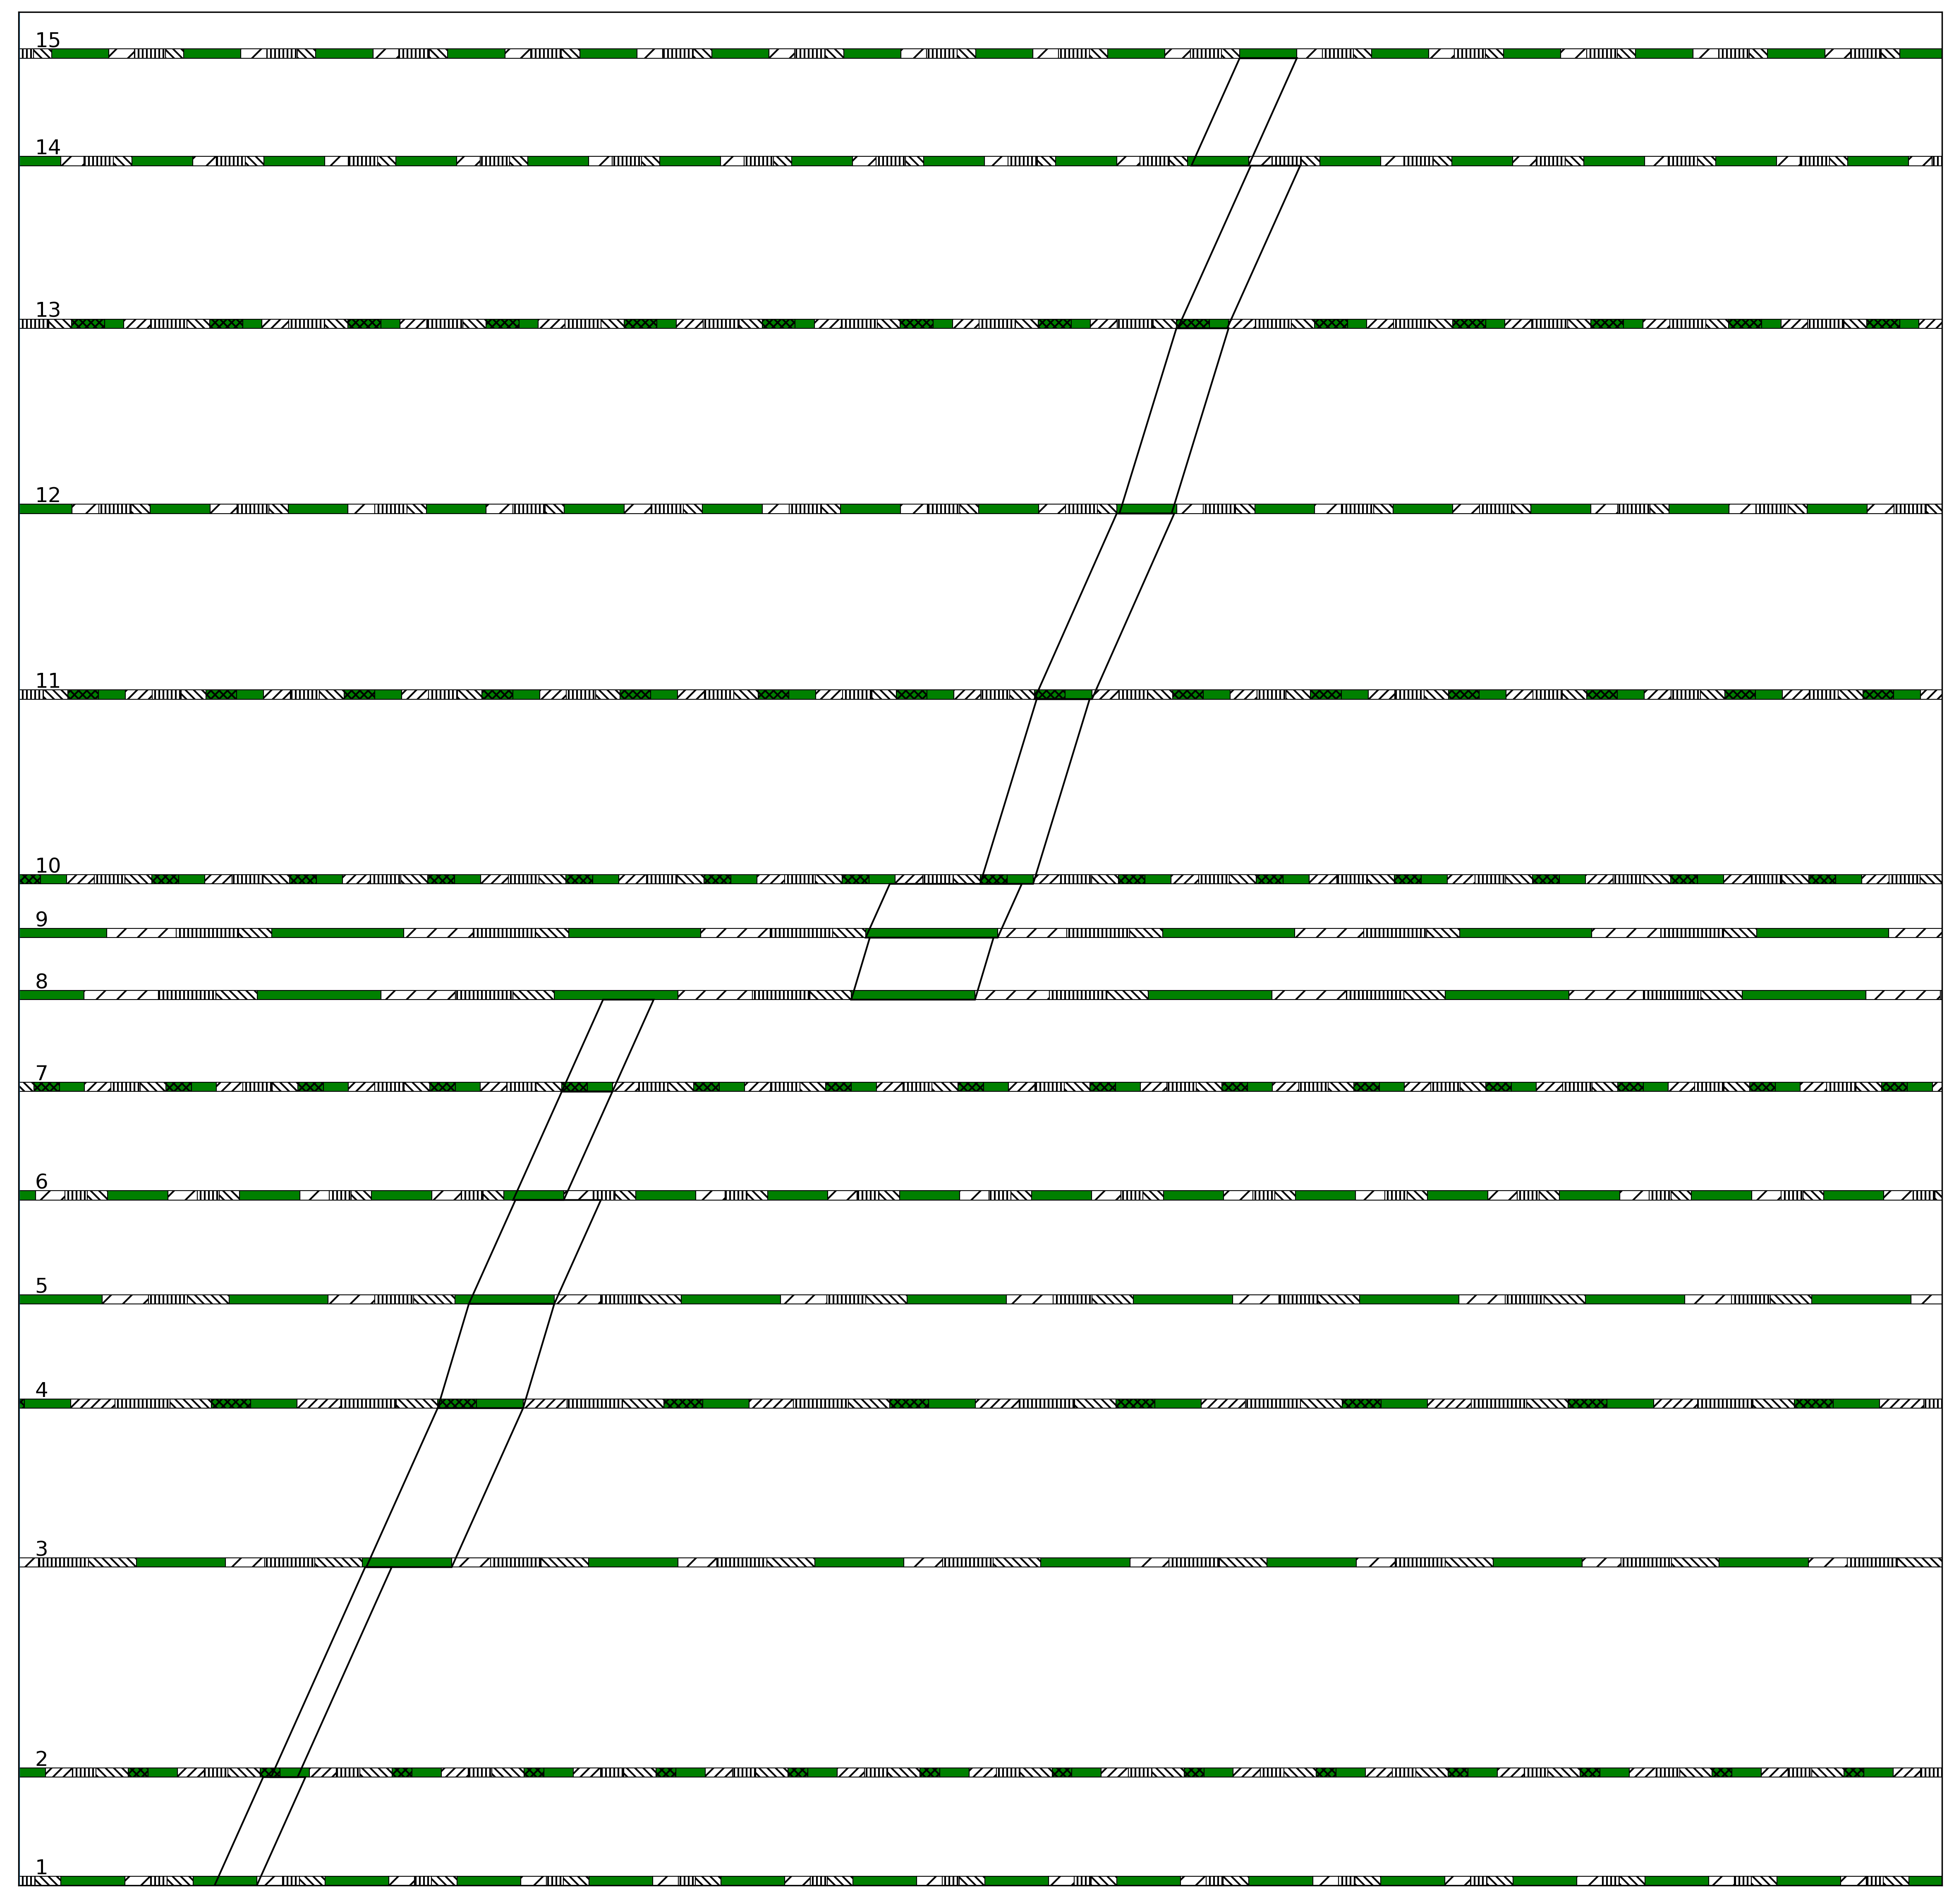

In [51]:
# color = ["red", "darkgray", "cyan", "g", "slateblue", "yellow"]
Df2=Df3.copy()
fig1 = plt.figure(figsize=(20, 20), dpi=300)
ax1 = fig1.add_subplot()
legends = ["1->15", "1->6", "8->15", "15->2", "14->9", "7->1"]
color = [
    {"color":"white" , "hatch": "|||||", "fill": True},
    {"color":"white", "hatch":"\\\\\\\\\\" , "fill": False},
    {"color": "white", "hatch":"xxxxx" , "fill": True},
    {"color":"white", "hatch": None, "fill": False},
    {"color": "white", "hatch": "////", "fill": False},
    {"color": "white", "hatch": "//", "fill": False}
]
Df2.car_t1 += Df2.z
Df2.car_t2 += Df2.z * 2
Df2.car_t3 += Df2.z * 3
for i in range(1, num):
    Df2.loc[i, "car_t1"] = data_formater(Df2.car_t1[i], Df2.car_t1[i - 1], i)
    Df2.loc[i, "car_t2"] = data_formater(Df2.car_t2[i], Df2.car_t2[i - 1], i)
    Df2.loc[i, "car_t3"] = data_formater(Df2.car_t3[i], Df2.car_t3[i - 1], i)

# Df2.car_t5 += Df2.z
# Df2.car_t6 += Df2.z * 2
for i in range(num - 1, 0, -1):
    Df2.loc[i - 1, "car_t4"] = data_formater(Df2.car_t4[i - 1], Df2.car_t4[i], i - 1)
    Df2.loc[i - 1, "car_t5"] = data_formater(Df2.car_t5[i - 1], Df2.car_t5[i], i - 1)
    Df2.loc[i - 1, "car_t6"] = data_formater(Df2.car_t6[i - 1], Df2.car_t6[i], i - 1)

max_width =max(Df2[["car_t1", "car_t2", "car_t3", "car_t4", "car_t5", "car_t6"]].max())+Df2.z.max()

max_hight = sum(Df.distance[0 : num - 1]) + 100
print(max_width,max_width/Df.z[0])
legendc = dict()
for i in range(0, num):
    offset_r = Df2.offset[i] - Df2.z[i]
    sum_dis = sum(Df2.distance[0:i])
    while offset_r < max_width:
        for j in range(0, len(green_time)):
            if green_time[j,i] == 0:
                continue
            else:
                if phase_get[0,i,j]==1:
                    ax1.add_patch(
                        plt.Rectangle(
                            (offset_r, sum(Df2.distance[0:i])),
                            green_time[j, i],
                            20,
                            facecolor="green",
                            hatch=color[j]["hatch"],
                            fill=True,
                            edgecolor='black',
                            linewidth=0.5
                        )
                    )
                else:
                    ax1.add_patch(
                        plt.Rectangle(
                            (offset_r, sum(Df2.distance[0:i])),
                            green_time[j, i],
                            20,
                            facecolor=color[j]["color"],
                            hatch=color[j]["hatch"],
                            fill=color[j]["fill"],
                            edgecolor='black',
                            linewidth=0.5
                        )
                    )
                offset_r += green_time[j,i]
    ax1.text(10, sum(Df2.distance[0:i]) + 25, str(i + 1), fontsize=12)
    
plt.plot([0, 0], [0, max_hight])
for i in range(0, num):
    dis = sum(Df2.distance[0:i])
    if Df2.b1[i] == 0:
        continue
    else:
        zip_x, zip_y = onbound(Df2.b1[i], Df2.car_t1[i], Df2.t1[i], dis, Df2.distance[i])
        onbound1 = ax1.add_patch(pch.Polygon(xy=list(zip(zip_x, zip_y)), fill=False,linewidth=1))

# for i in range(0, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b2[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = onbound(Df2.b2[i], Df2.car_t2[i], Df2.t1[i], dis, Df2.distance[i])
#         onbound2 = ax1.add_patch(pch.Polygon(xy=list(zip(zip_x, zip_y)), fill=False,linewidth=1))

# for i in range(0, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b3[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = onbound(Df2.b3[i], Df2.car_t3[i], Df2.t1[i], dis, Df2.distance[i])
#         onbound3 = ax1.add_patch(pch.Polygon(xy=list(zip(zip_x, zip_y)),fill=False,linewidth=1))
# for i in range(1, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b4[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = inbound(Df2.b4[i], Df2.car_t4[i], Df2.t2[i -1], dis, Df2.distance[i - 1])
#         inbound1 = ax1.add_patch(pch.Polygon(xy=list(zip(zip_x, zip_y)),fill=False,linewidth=1))

# for i in range(1, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b5[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = inbound(Df2.b5[i], Df2.car_t5[i], Df2.t2[i - 1], dis, Df2.distance[i - 1])
#         inbound2 = ax1.add_patch(pch.Polygon(xy=list(zip(zip_x, zip_y)),fill=False,linewidth=1))

# for i in range(1, num):
#     dis = sum(Df2.distance[0:i])
#     if Df2.b6[i] == 0:
#         continue
#     else:
#         zip_x, zip_y = inbound(Df2.b6[i], Df2.car_t6[i], Df2.t2[i-1], dis, Df2.distance[i - 1])
#         inbound3 = ax1.add_patch(pch.Polygon(xy=list(zip(zip_x, zip_y)),fill=False,linewidth=1))
plt.xlim([0,max_width,])
plt.ylim(0, sum(Df.distance[0 : num - 1]) + 100)
# ax2.set_xticks([])
# ax2.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.legend(
#     handles=[onbound1, onbound2, onbound3, inbound1, inbound2, inbound3],
#     labels=["path{}:".format(i) + legends[i - 1] for i in range(1, 7)],
#     fontsize=18,
#     loc="center right",
# )
# fig1.savefig(
#     r"./时距图", bbox_inches="tight"
# )

## 绘制公交图像

1165.7777777777774 14.572222222222225


[]

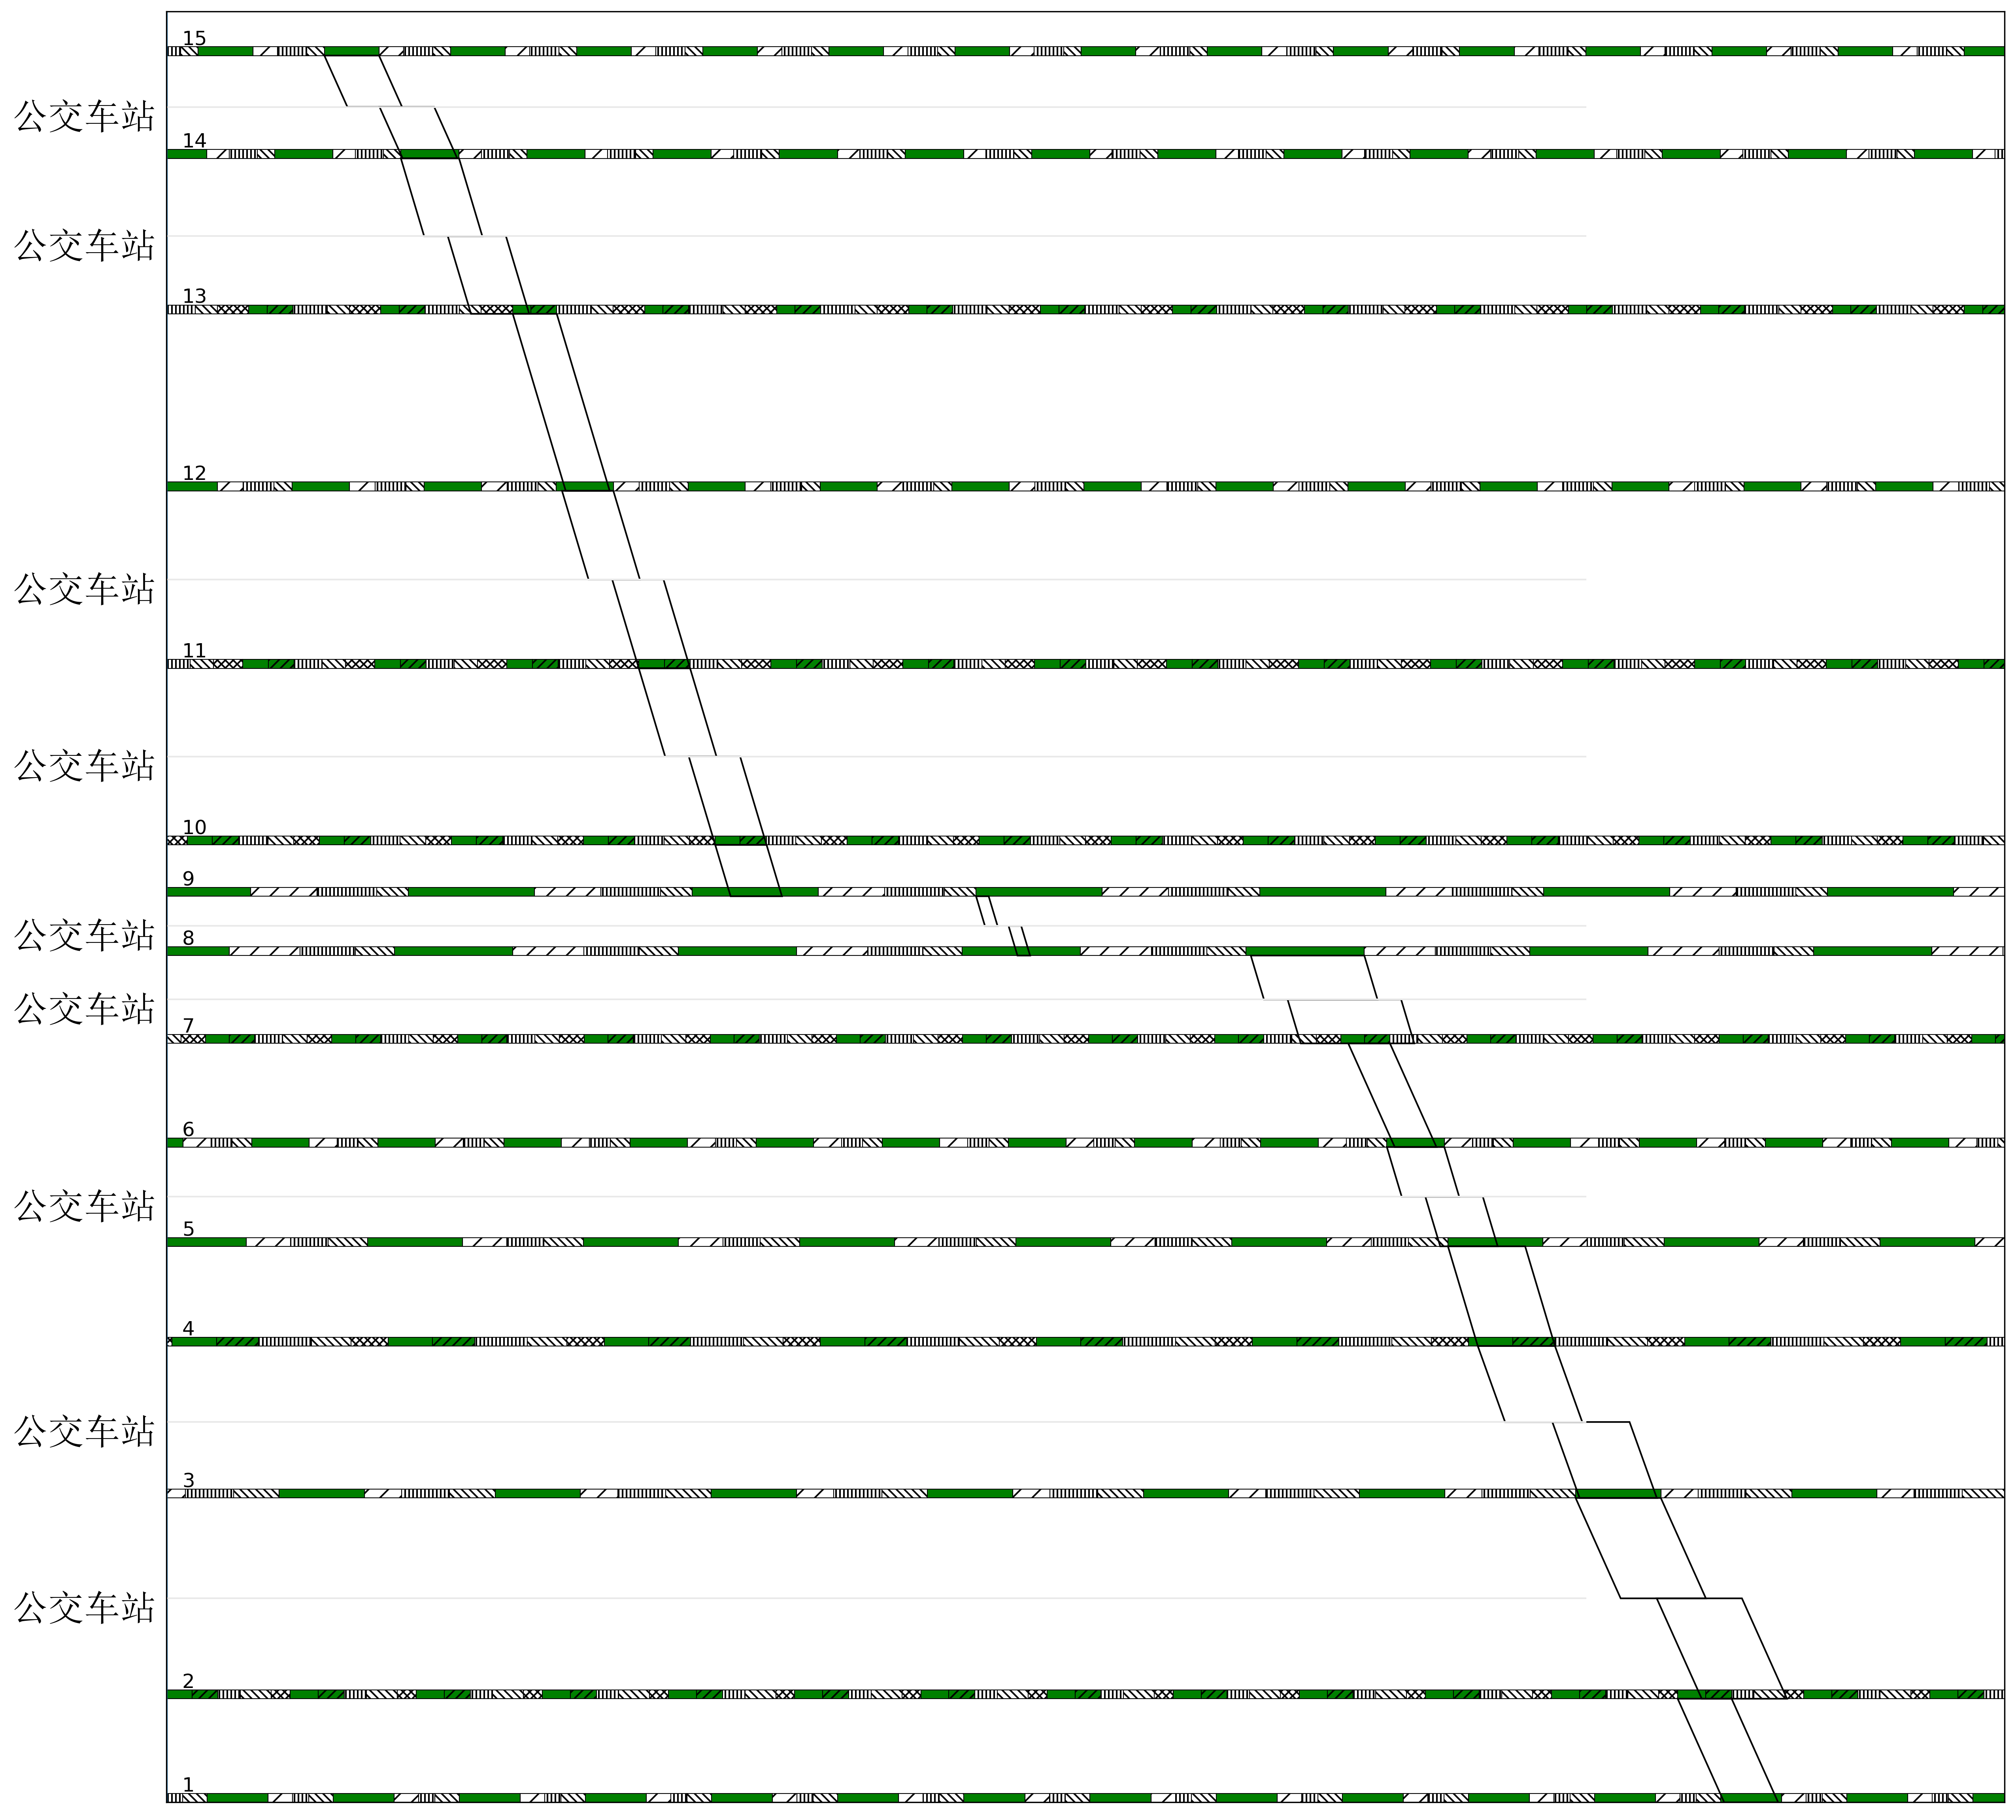

In [52]:
# color = ["red", "darkgray", "cyan", "g", "slateblue", "yellow"]
Df2=Df3.copy()
font1 = {'family': 'SimSun', 'size': 22, 'weight': 'normal'}
bus_stop=[ex[i]*(sum(Df.distance[0:i])+Df.distance[i]*0.5) for i in range(0,num-1)]
fig1 = plt.figure(figsize=(20, 20), dpi=300)
ax1 = fig1.add_subplot()
legends = ["1->15", "1->6", "8->15", "15->2", "14->9", "7->1"]
color = [
    {"color":"white" , "hatch": "|||||", "fill": True},
    {"color":"white", "hatch":"\\\\\\\\\\" , "fill": False},
    {"color": "white", "hatch":"xxxxx" , "fill": True},
    {"color":"white", "hatch": None, "fill": False},
    {"color": "white", "hatch": "////", "fill": False},
    {"color": "white", "hatch": "//", "fill": False}
]
Df2.bus_t1 += Df2.z
for i in range(1, num):
    Df2.loc[i, "bus_t1"] = data_formater(Df2.bus_t1[i], Df2.bus_t1[i - 1], i)


for i in range(num - 1, 0, -1):
    Df2.loc[i - 1, "bus_t2"] = data_formater(Df2.bus_t2[i - 1], Df2.bus_t2[i], i - 1)
#     Df2.loc[i - 1, "car_t5"] = data_formater(Df2.car_t5[i - 1], Df2.car_t5[i], i - 1)
#     Df2.loc[i - 1, "car_t6"] = data_formater(Df2.car_t6[i - 1], Df2.car_t6[i], i - 1)

max_width =max(Df2[["bus_t1", "bus_t2"]].max())+Df2.z.max()

max_hight = sum(Df.distance[0 : num - 1]) + 100
print(max_width,max_width/Df.z[0])
legendc = dict()
for i in range(0, num):
    offset_r = Df2.offset[i] - Df2.z[i]
    sum_dis = sum(Df2.distance[0:i])
    while offset_r < max_width:
        for j in range(0, len(green_time)):
            if green_time[j,i] == 0:
                continue
            else:
                if straight_get[1,i,j]==1:
                    ax1.add_patch(
                        plt.Rectangle(
                            (offset_r, sum(Df2.distance[0:i])),
                            green_time[j, i],
                            20,
                            facecolor="green",
                            hatch=color[j]["hatch"],
                            fill=True,
                            edgecolor='black',
                            linewidth=0.5
                        )
                    )
                else:
                    ax1.add_patch(
                        plt.Rectangle(
                            (offset_r, sum(Df2.distance[0:i])),
                            green_time[j, i],
                            20,
                            facecolor=color[j]["color"],
                            hatch=color[j]["hatch"],
                            fill=color[j]["fill"],
                            edgecolor='black',
                            linewidth=0.5
                        )
                    )
                offset_r += green_time[j,i]
    ax1.text(10, sum(Df2.distance[0:i]) + 25, str(i + 1), fontsize=12)
    
plt.plot([0, 0], [0, max_hight])
    #绘制公交车站
for i in range(0,num-1):
    flag=bus_stop[i]
    if flag!=0: 
        plt.plot([-100,900],[bus_stop[i],bus_stop[i]],color=sns.color_palette('Greys',5)[0],linewidth=1)
        ax1.text(-98,bus_stop[i]-50,'公交车站',fontdict=font1)

# for i in range(0,num-1):
#     dis=sum(Df2.distance[0:i])
#     if Df2.bb1[i]==0:
#         continue
#     else:
#         if bus_stop[i]>0:
#             bus_dis=(bus_stop[i]-dis)
#             zip_x,zip_y=onbound(Df2.bb1[i],Df2.bus_t1[i],bus_dis/Df2.on_bus_v1[i],dis,bus_dis)
#             ax1.add_patch(pch.Polygon(xy=list(zip(zip_x,zip_y)),fill=False,linewidth=1))

#             zip_x,zip_y=onbound(Df2.bb1[i],Df2.bus_t1[i]+bus_dis/Df2.on_bus_v1[i]+Df2.dw1[i],
#             bus_dis/Df2.on_bus_v1[i],dis+bus_dis,bus_dis)
#             ax1.add_patch(pch.Polygon(xy=list(zip(zip_x,zip_y)),fill=False,linewidth=1))
#         else:
#             zip_x,zip_y=onbound(Df2.bb1[i],Df2.bus_t1[i],Df2.tb1[i],dis,Df.distance[i])
#             ax1.add_patch(pch.Polygon(xy=list(zip(zip_x,zip_y)),fill=False,linewidth=1))

for i in range(1,num):
    dis=sum(Df2.distance[0:i])
    if Df2.bb2[i]==0:
        continue
    else:
        if bus_stop[i-1]>0:
            bus_dis=dis-bus_stop[i-1]
            zip_x,zip_y=inbound(Df2.bb2[i],Df2.bus_t2[i],bus_dis/Df2.in_bus_v1[i-1],dis,bus_dis)
            ax1.add_patch(pch.Polygon(xy=list(zip(zip_x,zip_y)),fill=False,linewidth=1))

            zip_x,zip_y=inbound(Df2.bb2[i],Df2.bus_t2[i]+bus_dis/Df2.in_bus_v1[i-1]+Df2.dw2[i-1],
            bus_dis/Df2.in_bus_v1[i-1],dis-bus_dis,bus_dis)
            ax1.add_patch(pch.Polygon(xy=list(zip(zip_x,zip_y)),fill=False,linewidth=1))
        else:
            zip_x,zip_y=inbound(Df2.bb2[i],Df2.bus_t2[i],Df2.tb2[i-1],dis,Df2.distance[i-1])
            ax1.add_patch(pch.Polygon(xy=list(zip(zip_x,zip_y)),fill=False,linewidth=1))


plt.xlim([0,max_width,])
plt.ylim(0, sum(Df.distance[0 : num - 1]) + 100)
# ax2.set_xticks([])
# ax2.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
# ax1.legend(
#     handles=[onbound1, onbound2, onbound3, inbound1, inbound2, inbound3],
#     labels=["path{}:".format(i) + legends[i - 1] for i in range(1, 7)],
#     fontsize=18,
#     loc="center right",
# )
# fig1.savefig(
#     r"./时距图", bbox_inches="tight"
# )

## 绘制速度波动图像

##### 临时计算方式

In [53]:
def get_var_on_cons(A, B, o, r, g, t, n, k, end, yp, px, p, sum_on,rho,pc,onbound,idx):
    if k>=end:
        return sum_on,onbound
    else:
        A1=max(A+t[k-1]-M*p[k],o[k]+r[k]+n[k]+px[k])
        B1=min(B+t[k-1]+M*p[k], o[k]+r[k]+n[k]+g[k])
        sum_on+=pc[k]*vol[0,k]*(B1-A1)
        onbound.append([A1,B1,B1-A1,A+t[k-1]-M*p[k],o[k]+r[k]+n[k]+px[k],B+t[k-1]+M*p[k], o[k]+r[k]+n[k]+g[k]])
        return get_var_on_cons(A1, B1, o, r, g, t, n, k+1, end, yp, px, p, sum_on,rho,pc,onbound,i)

In [54]:
sum_on=0
sum_in=0
onbound2=[]
for i,v in enumerate(linspace):
    tmp,onb=get_var_on_cons(
        A=o[0]+srf[0,0],
        B=o[0]+srf[0,0]+sg[0,0],
        o=o,
        r=srf[0],
        g=sg[0],
        t=np.array([d[j]/v*z[j] for j in range(num-1)]),
        n=np.array([nt[0,j,i] for j in range(num)]),
        k=1,
        end=num,
        yp=np.array([yp[0,j,i] for j in range(num)]),
        px=px[0],
        p=np.array([p[k] for k in range(num)]),
        sum_on=sum_on,
        rho=rho,
        pc=np.array([pc[0,j,i] for j in range(num)]),
        onbound=[[o[0]+srf[0,0],o[0]+srf[0,0]+sg[0,0],o[0]+sg[0,0],o[0]+srf[0,0],o[0]+srf[0,0],o[0]+srf[0,0]+sg[0,0],o[0]+srf[0,0]+sg[0,0]]],
        idx=i
    )
    sum_on+=tmp*ProDistribution[i]
    onbound2.append(onb)

In [55]:
onbound2=np.array(onbound2)

In [56]:
bound1=pd.DataFrame(onbound2[0])
bound1.columns=["A","B","B-A","Al","Ar","Bl","Br"]
bound1["t"]=[d[j]/linspace[0]*z[j] for j in range(num-1)]+[np.nan]
bound1["pc"]=[pc[0,i,0] for i in range(num)]
bound1["p"]=[p[i] for i in range(num)]
bound1["yp"]=[yp[0,i,0] for  i in range(num)]
bound1["Bl-Ar"]=bound1[["Bl","Br"]].min(axis=1)-bound1[["Al","Ar"]].max(axis=1)
bound1["B-A_"]=bound1["B"]-bound1["A"]
bound1["Al+t"]=bound1["A"]+bound1["t"]

In [57]:
bound1

,A,B,B-A,Al,Ar,Bl,Br,t,pc,p,yp,Bl-Ar,B-A_,Al+t
0,0.322222,0.805556,0.483333,0.322222,0.322222,8.055556e-01,0.805556,0.368750,0.0,0.0,1.0,0.483333,0.483333,0.690972
1,0.831250,1.174306,0.343056,0.690972,0.831250,1.174306e+00,1.203472,0.714063,1.0,0.0,1.0,0.343056,0.343056,1.545313
2,0.521875,0.916319,0.394444,-999998.454688,0.521875,1.000002e+06,0.916319,0.315597,0.0,1.0,1.0,0.394444,0.394444,0.837472
3,0.854139,1.231917,0.377778,0.837472,0.854139,1.231917e+00,1.231917,0.207054,0.0,0.0,1.0,0.377778,0.377778,1.061193
4,1.061193,1.369952,0.308760,1.061193,0.931064,1.438970e+00,1.369952,0.206142,1.0,0.0,1.0,0.308760,0.308760,1.267334
5,0.675775,1.131331,0.455556,-999998.732666,0.675775,1.000002e+06,1.131331,0.368750,0.0,1.0,1.0,0.455556,0.455556,1.044525
6,1.116747,1.500081,0.383333,1.044525,1.116747,1.500081e+00,1.500081,0.312500,1.0,0.0,1.0,0.383333,0.383333,1.429247
7,0.804247,1.220914,0.416667,-999998.570753,0.804247,1.000002e+06,1.220914,0.093750,0.0,1.0,1.0,0.416667,0.416667,0.897997
8,0.897997,1.297303,0.399306,0.897997,0.852858,1.314664e+00,1.297303,0.081250,1.0,0.0,1.0,0.399306,0.399306,0.979247
9,0.964664,1.347997,0.383333,-999999.020753,0.964664,1.000001e+06,1.347997,0.600392,0.0,1.0,0.0,0.383333,0.383333,1.565056


#### 当前计算方式

In [58]:
onbound3=[]
for i in range(lin_num):
    tmp=[]
    for k in range(num):
        tmp.append([sol.get_value(onbound_x[i][k][0]),sol.get_value(onbound_x[i][k][1]),sol.get_value(onbound_x[i][k][2])])
    onbound3.append(tmp)

In [59]:
bod=pd.DataFrame(onbound3[1])
bod.columns=["A","B","B-A"]
bod["C"]=[C[0,k,1] for k in range(num)]
bod["pc"]=[pc[0,i,1] for i in range(num)]
bod["p"]=[p[i] for i in range(num)]
bod["yp"]=[yp[0,i,1] for  i in range(num)]
bod["z"]=Df.z

In [60]:
bod.round(2)

,A,B,B-A,C,pc,p,yp,z
0,0.32,0.81,0.48,0.00,0.0,0.0,1.0,80.00
1,0.83,1.13,0.30,0.30,1.0,0.0,1.0,80.00
2,0.52,0.92,0.39,0.00,0.0,1.0,1.0,137.04
3,0.85,1.20,0.34,0.00,0.0,0.0,1.0,137.04
4,1.04,1.37,0.33,0.33,1.0,0.0,1.0,137.04
5,0.68,1.13,0.46,0.00,0.0,1.0,1.0,80.00
6,1.12,1.46,0.34,0.34,1.0,0.0,1.0,80.00
7,0.80,1.22,0.42,0.00,0.0,1.0,1.0,180.00
8,0.89,1.30,0.41,0.41,1.0,0.0,1.0,180.00
9,0.96,1.35,0.38,0.00,0.0,1.0,1.0,83.70


In [61]:
onbound4=[]
for i in range(lin_num):
    tmp=[]
    for k in range(num):
        tmp.append([sol.get_value(inbound_x[i][k][0]),sol.get_value(inbound_x[i][k][1]),sol.get_value(inbound_x[i][k][2])])
    tmp=[tmp[i] for i in range(len(tmp)-1,-1,-1)]
    onbound4.append(tmp)

In [62]:
ibod=pd.DataFrame(onbound4[1])
ibod.columns=["A","B","B-A"]
ibod["C"]=[C[1,k,1] for k in range(num)]
ibod["pc"]=[pc[1,i,1] for i in range(num)]
ibod["p"]=[p[i] for i in range(num)]
ibod["yp"]=[yp[1,i,1] for  i in range(num)]
ibod["z"]=Df.z

In [63]:
ibod.round(2)

,A,B,B-A,C,pc,p,yp,z
0,5.48,0.81,-4.68,0.00,0.0,0.0,0.0,80.00
1,5.16,1.41,-3.75,0.00,0.0,0.0,0.0,80.00
2,4.52,4.71,0.19,0.19,1.0,1.0,1.0,137.04
3,4.12,4.43,0.31,0.00,0.0,0.0,1.0,137.04
4,3.93,4.31,0.38,0.00,0.0,0.0,1.0,137.04
5,3.68,3.83,0.15,0.15,1.0,1.0,1.0,80.00
6,3.31,3.50,0.19,0.00,0.0,0.0,1.0,80.00
7,4.31,2.38,-1.93,0.00,0.0,1.0,0.0,180.00
8,4.23,2.30,-1.93,0.00,0.0,0.0,0.0,180.00
9,4.23,4.40,0.17,0.17,1.0,1.0,1.0,83.70
